# XAI techniques for Linear Regression and GAM
### - InModeling XAI
### - PostHoc XAI

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import shap
from lime.lime_tabular import LimeTabularExplainer
import warnings
from pygam import LinearGAM, s
import lime
import lime.lime_tabular
from sklearn.inspection import PartialDependenceDisplay

warnings.filterwarnings("ignore", message="KNOWN BUG: p-values computed in this summary")


In [2]:
data = pd.read_csv("wnba_clean.csv")

In [3]:
data.head()

,shot_type,made_shot,shot_value,coordinate_x,coordinate_y,home_score,away_score,qtr,quarter_seconds_remaining,game_seconds_remaining,shot_group,distance,shot_group_encoded,shot_type_encoded
0,Jump Shot,False,0,-13,9,0,0,1,571,2371,Jump Shot,15.811388,3,29
1,Turnaround Bank Jump Shot,False,0,0,0,0,0,1,551,2351,Jump Shot,0.000000,3,8
2,Cutting Layup Shot,True,2,-21,2,0,2,1,538,2338,Layup,21.095023,1,25
3,Driving Layup Shot,True,2,0,0,2,2,1,524,2324,Layup,0.000000,1,14
4,Jump Shot,True,3,0,21,2,5,1,512,2312,Jump Shot,21.000000,3,29


### Selecting only the necessary attributes for model training

In [4]:
selected_features = ['coordinate_x', 'coordinate_y', 'distance', 'shot_group_encoded', 'shot_type_encoded']

In [5]:
X = data[selected_features]
y = data['made_shot']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


## Linear Regression

In [7]:
# Train a Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared (R2): {r2:.2f}")


Mean Squared Error (MSE): 0.23
R-squared (R2): 0.09


### InModeling XAI

              Feature  Coefficient
3  shot_group_encoded     0.024265
4   shot_type_encoded     0.006334
2            distance     0.004696
0        coordinate_x    -0.002705
1        coordinate_y    -0.015276


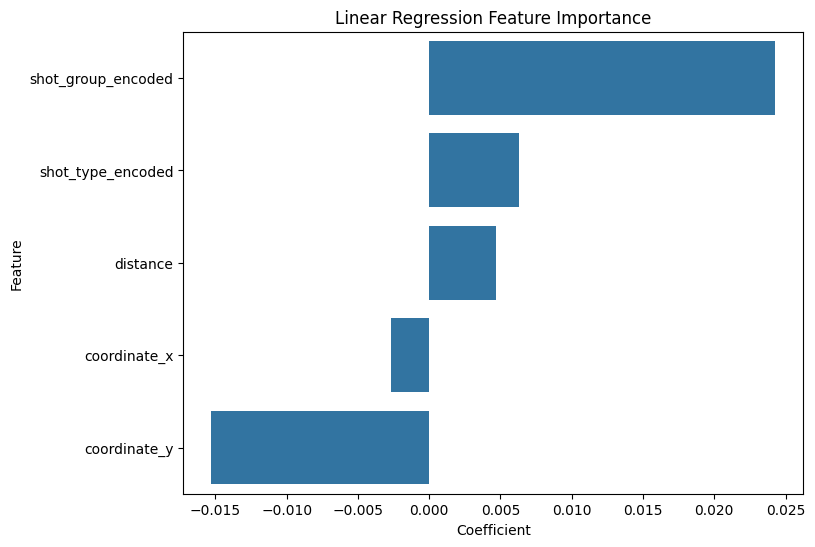

In [8]:
# Visualizing coefficients for feature importance
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_
})
coefficients = coefficients.sort_values(by='Coefficient', ascending=False)
print(coefficients)

plt.figure(figsize=(8, 6))
sns.barplot(x='Coefficient', y='Feature', data=coefficients)
plt.title('Linear Regression Feature Importance')
plt.show()


This plot shows the feature importance based on the coefficients of a linear regression model. The shot_group_encoded feature has the largest positive impact on the target variable, while coordinate_y has the largest negative impact. Other features like shot_type_encoded and distance contribute less significantly to the model.

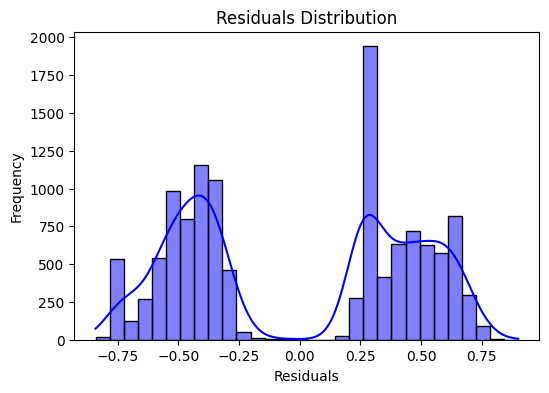

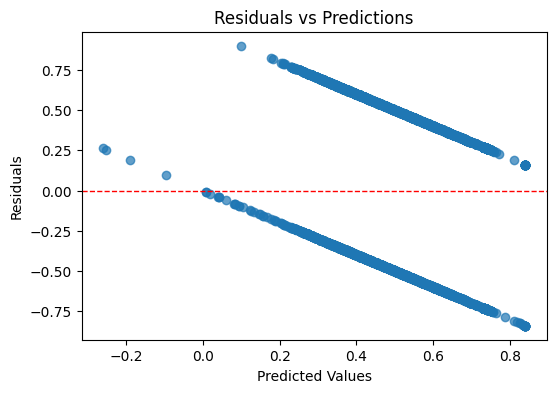

In [27]:
# Residuals
residuals = y_test - y_pred

# Plot residuals
plt.figure(figsize=(6, 4))
sns.histplot(residuals, kde=True, color='blue', bins=30)
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Residuals vs Predictions
plt.figure(figsize=(6, 4))
plt.scatter(y_pred, residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title('Residuals vs Predictions')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()


The top plot shows the residual distribution, indicating non-normality and the presence of multiple peaks, suggesting model misspecification or unaccounted patterns. The bottom plot, Residuals vs. Predictions, reveals clear heteroscedasticity and a structured pattern, indicating the model fails to capture all relationships in the data.

### Post Hoc XAI

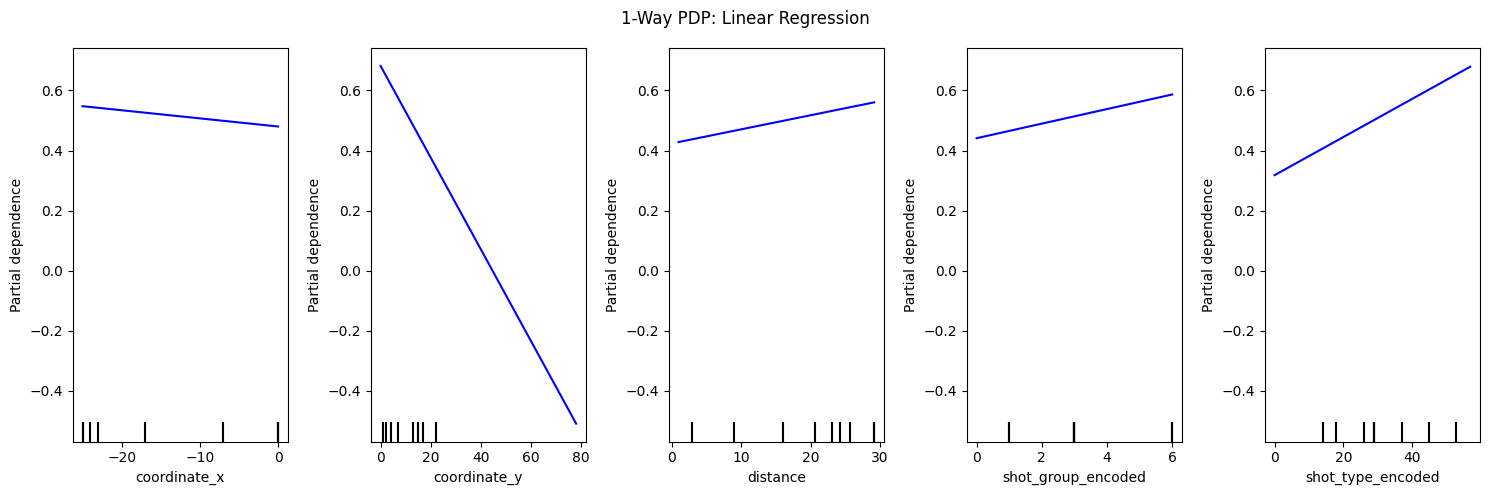

In [10]:

# 1-way PDP for both models (individual features)
features = [0, 1, 2, 3, 4]  # Adjust these to your features' indices
fig, axs = plt.subplots(1, len(features), figsize=(15, 5))
PartialDependenceDisplay.from_estimator(model, X_train, features, ax=axs, line_kw={"color": "blue"})
plt.suptitle("1-Way PDP: Linear Regression")
plt.tight_layout()
plt.show()


These Partial Dependence Plots (PDPs) illustrate the marginal effect of each feature on the model's predictions, and because of the linearity of the model the relations are very easy to see. coordinate_y has a strong negative effect, while shot_group_encoded, shot_type_encoded, and distance exhibit positive linear trends. coordinate_x shows a smaller, slight negative relationship. This highlights the varying impact of each feature on the linear regression output. 

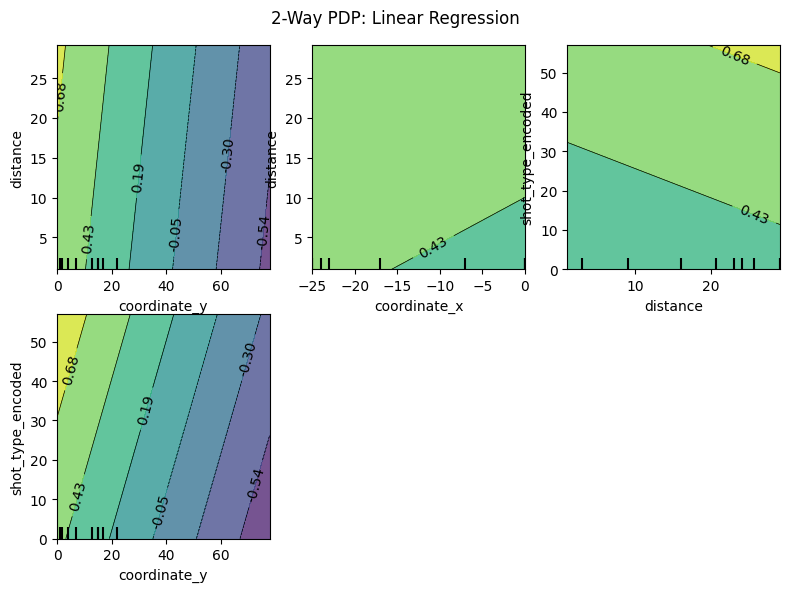

In [12]:
# 2-way PDP for feature interactions
interaction_features = [(1, 2), (0,2), (2,4), (1,4)]  
# For Linear Regression
fig, ax = plt.subplots(figsize=(8, 6))
PartialDependenceDisplay.from_estimator(model, X_train, interaction_features, ax=ax)
plt.suptitle("2-Way PDP: Linear Regression")
plt.tight_layout()
plt.show()

These 2-Way Partial Dependence Plots (PDPs) show the combined effects of two features on the model's predictions. Key observations include:

coordinate_y vs. distance and shot_type_encoded vs. coordinate_y display clear linear gradients, with higher values of coordinate_y reducing predictions.
distance vs. coordinate_x and distance vs. shot_type_encoded reveal interaction patterns where certain combinations yield higher predictions.
The model's predictions vary smoothly across the feature combinations, suggesting limited nonlinear interactions.

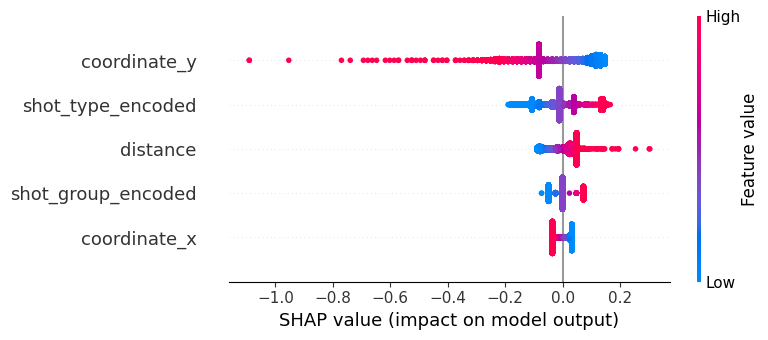

In [13]:
# Initialize SHAP explainer
explainer = shap.LinearExplainer(model, X_train)
shap_values = explainer(X_test)

# SHAP summary plot
shap.summary_plot(shap_values.values, X_test, feature_names=X_test.columns)


This SHAP summary plot shows the impact of each feature on the model's predictions.

coordinate_y has the largest negative impact, with higher values (red) decreasing predictions significantly.
shot_type_encoded and distance show a mix of positive and negative impacts, depending on the feature value.
Features like coordinate_x and shot_group_encoded contribute less, as indicated by smaller SHAP value spreads.

## Linear GAM

The GAM effectively captures both linear and nonlinear dependencies across features.

In [15]:
gam = LinearGAM()
gam.fit(X,y)

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, 
   terms=s(0) + s(1) + s(2) + s(3) + s(4) + intercept, tol=0.0001, 
   verbose=False)

### InModeling XAI

In [16]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     63.4931
Link Function:                     IdentityLink Log Likelihood:                                -70393.7503
Number of Samples:                        41497 AIC:                                           140916.4869
                                                AICc:                                          140916.6908
                                                GCV:                                                0.2168
                                                Scale:                                              0.2162
                                                Pseudo R-Squared:                                   0.1355
Feature Function                  Lam

### Post Hoc XAI

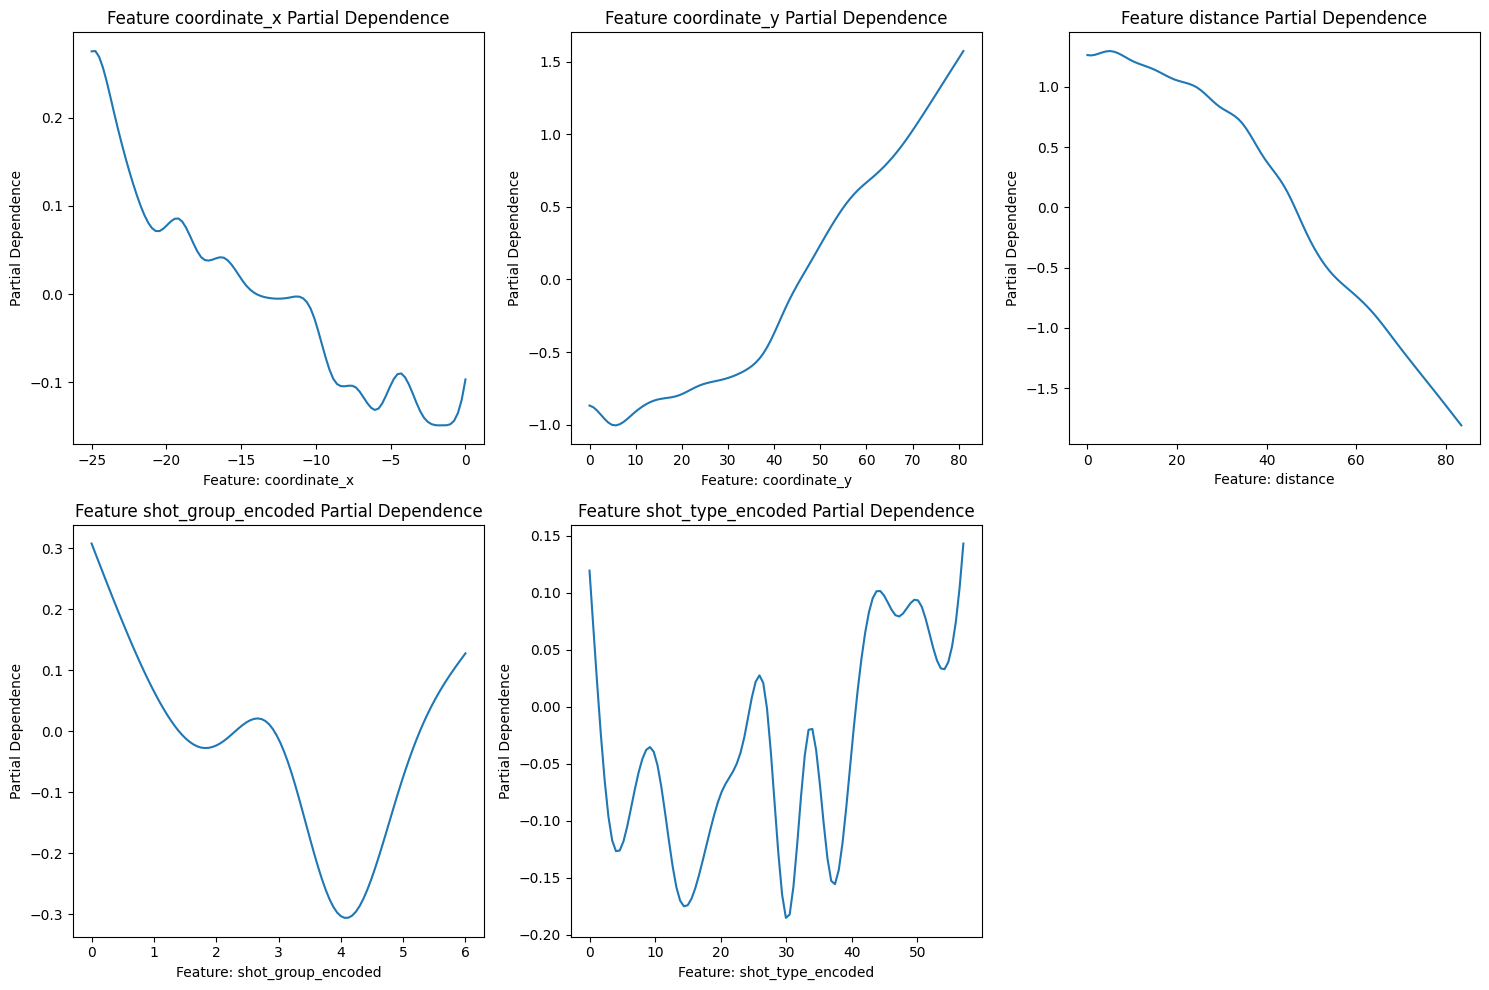

<Figure size 640x480 with 0 Axes>

In [24]:

# Create a grid of subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))  # Adjust to match the number of features
axs = axs.flatten()  # Flatten the 2D grid into a 1D array for iteration

# Plot partial dependence for each feature
for i in range(len(axs)):
    if i >= len(X_train.columns):  # Avoid plotting for extra subplots
        axs[i].axis('off')  # Turn off unused subplots
        continue
    XX = gam.generate_X_grid(term=i)  # Generate values for the i-th feature
    axs[i].plot(XX[:, i], gam.partial_dependence(term=i, X=XX))  # Plot partial dependence
    axs[i].set_title(f'Feature {X_train.columns[i]} Partial Dependence')
    axs[i].set_xlabel(f'Feature: {X_train.columns[i]}')
    axs[i].set_ylabel('Partial Dependence')

plt.tight_layout()
plt.show()
plt.savefig("example_plot.png", format='png', dpi=300)

These Partial Dependence Plots (PDPs) for a Generalized Additive Model (GAM) show the individual contributions of each feature to the model’s predictions:

coordinate_x: Displays a decreasing nonlinear trend with slight fluctuations.
coordinate_y: Shows a strong positive linear relationship with predictions.
distance: Exhibits a steep decline, indicating a significant negative impact as values increase.
shot_group_encoded and shot_type_encoded: Reveal complex, non-monotonic relationships, suggesting these features have nonlinear effects on predictions.

Because GAMs also captures nonlinear relations, the plots are more informative, displaying insteresting variations in influence throughout the feature's values increase

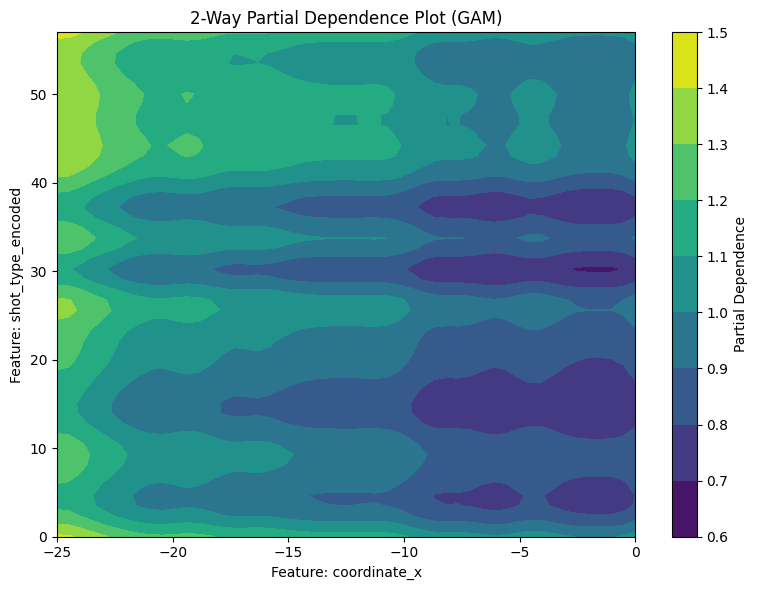

In [18]:
# Select two feature indices for interaction
feature1_idx = 0  
feature2_idx = 4  

# Define the range for each feature
feature1_range = np.linspace(X_train.iloc[:, feature1_idx].min(), X_train.iloc[:, feature1_idx].max(), 50)
feature2_range = np.linspace(X_train.iloc[:, feature2_idx].min(), X_train.iloc[:, feature2_idx].max(), 50)

# Create a grid of values for the two features
feature1_grid, feature2_grid = np.meshgrid(feature1_range, feature2_range)

# Prepare the grid for GAM predictions
grid_data = np.zeros((feature1_grid.size, X_train.shape[1]))
grid_data[:, feature1_idx] = feature1_grid.ravel()
grid_data[:, feature2_idx] = feature2_grid.ravel()

# Predict partial dependence values
pd_values = gam.predict(grid_data).reshape(feature1_grid.shape)

# Plot 2-way Partial Dependence heatmap
plt.figure(figsize=(8, 6))
contour = plt.contourf(feature1_grid, feature2_grid, pd_values, cmap='viridis')
plt.colorbar(contour, label='Partial Dependence')
plt.xlabel(f'Feature: {X_train.columns[feature1_idx]}')
plt.ylabel(f'Feature: {X_train.columns[feature2_idx]}')
plt.title('2-Way Partial Dependence Plot (GAM)')
plt.tight_layout()
plt.show()

this 2-Way Partial Dependence Plot (PDP) for the GAM shows the joint effects of coordinate_x and shot_type_encoded on model predictions.

We selected this pair of features because we anticipated it would reveal interesting interactions between spatial coordinates (coordinate_x) and shot types, potentially highlighting zones where shot type has a greater impact. The plot confirms subtle nonlinear dependencies, with higher shot_type_encoded values and specific regions of coordinate_x yielding higher partial dependence values. These insights help understand how location and shot characteristics interact to influence predictions.

In [19]:
# Predict feature contributions
feature_contributions = np.array([
    gam.partial_dependence(term=i, X=X_test) for i in range(X_test.shape[1])
])

# Transpose to match SHAP's expected shape
shap_values = feature_contributions.T  # Shape: (n_samples, n_features)

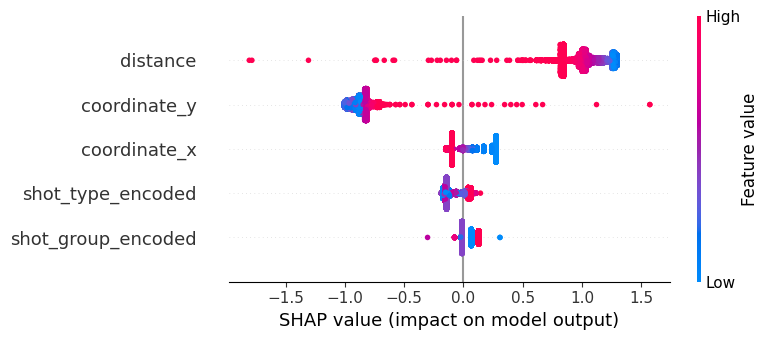

In [20]:
# Convert to SHAP's format
explainer = shap.Explanation(
    values=shap_values,
    base_values=gam.predict(X_test),
    data=X_test,
    feature_names=X_test.columns
)

# SHAP summary plot
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)


This SHAP summary plot for the GAM highlights the impact of each feature on the model’s output:

distance has the largest positive impact, with high values (red) increasing predictions significantly.
coordinate_y contributes mostly negative SHAP values, particularly when feature values are high.
Other features like coordinate_x and shot_type_encoded show more nuanced effects, with smaller SHAP spreads.
This visualization reinforces the importance of distance and coordinate_y in driving the GAM’s predictions while capturing both linear and nonlinear relationships.